In [11]:
include("../../datatools.jl")
using  LinearAlgebra, Plots, CSV, DataFrames, Optim, DataStructures, Statistics

In [12]:
function get_spaced_nodes2d(x, y, z, n=10; fluctuation::Int=0)
     len = length(x)
     indices = round.(Int, LinRange(1, len, n))


     for i = 2:length(indices)-1
        indices[i] += rand((-1 * fluctuation):fluctuation)
     end
    
     xs = x[indices]
     ys = y[indices]
     zs = z[indices]

     return xs, ys, zs
 end

get_spaced_nodes2d (generic function with 2 methods)

In [13]:
function fit_model_to_data(xs, ys, model_func, initial_params; n=100)
     #scale the x-values
     scaled_xs = @. (xs - 29.6) * 100
     
     # get training samples
     train_xs, train_ys = get_spaced_nodes(scaled_xs, ys, n)


     # setup cost/loss function
     function loss(params)
          predicted_y = model_func(train_xs, params...)
          return sum((train_ys - predicted_y) .^ 2)
     end

     # optimize the loss function
     opt_res = optimize(loss, initial_params)
     opt_params = Optim.minimizer(opt_res)

     # fit data
     fitted_ys = model_func(scaled_xs, opt_params...)

     # sort so points returned are in increasing latitudes (for plotting)
     temp = DataFrame(x=xs, y = fitted_ys)
     sort!(temp, :x)

     return temp.x, temp.y
end

fit_model_to_data (generic function with 1 method)

In [14]:
function fit_model_to_data2d(xs, ys, zs, model_func, initial_params; n=100, test_grid=100)
     
     # get training samples
     train_xs, train_ys, train_zs = get_spaced_nodes2d(xs, ys, zs, n)

     # setup cost/loss function
     function loss(params)
          predicted_z = model_func(train_xs, train_ys, params...)
          return sum((train_zs - predicted_z) .^ 2)
     end

     # optimize the loss function
     opt_res = optimize(loss, initial_params)
     opt_params = Optim.minimizer(opt_res)


     test_xs = []
     test_ys = []
     for i = range(minimum(xs), maximum(xs), test_grid)
          for j = range(minimum(ys), maximum(ys), test_grid)
               push!(test_xs, i)
               push!(test_ys, j)
          end
     end

     # fit data
     fitted_zs = model_func(test_xs, test_ys, opt_params...)

     # sort so points returned are in increasing latitudes (for plotting)
     temp = DataFrame(latitude=test_xs, longitude = test_ys, altitude = fitted_zs)
     sort!(temp, :latitude)

     return temp
     
end

fit_model_to_data2d (generic function with 1 method)

In [15]:
function sinny(x, y, a, b, c, d, e)
     return @. a*sin(b*x) + c*sin(d*y) + e*x
end

sinny (generic function with 1 method)

In [16]:
df = stack_all_streets(get_all_dataframes());
dfsc = scale_coordinates(df);

xs = dfsc.latitude;
ys = dfsc.longitude;
zs = dfsc.altitude;

guess = [3.0, 1.0, 5.0, 1.0, 5.0]

ft = fit_model_to_data2d(xs, ys, zs, sinny, guess; n=14000, test_grid=100);

og_ft = unscale_coordinates(ft);

In [17]:

# CSV.write("2dtest.csv", og_ft)

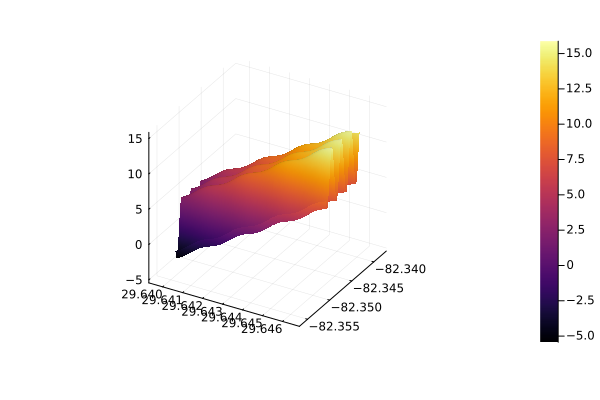

In [18]:
surface(og_ft.latitude, og_ft.longitude, og_ft.altitude, aspect_ratio=0.25)